In [14]:
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
import pandas as pd
import torch
import sklearn
import torchvision

import sys
import os

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "../src")))

In [20]:
class CharData:
    i_penetration: np.ndarray
    j_penetration: np.ndarray

    top_depth: np.ndarray
    left_depth: np.ndarray

    image_width: int
    image_height: int
    sample_count: int

    # def resample(self, target_samples: int):
    #     i_resampled = np.interp(
    #         np.linspace(0, len(self.i_penetration) - 1, target_samples),
    #         np.arange(len(self.i_penetration)),
    #         self.i_penetration,
    #     )
    #     j_resampled = np.interp(
    #         np.linspace(0, len(self.j_penetration) - 1, target_samples),
    #         np.arange(len(self.j_penetration)),
    #         self.j_penetration,
    #     )

    #     self.i_penetration = i_resampled
    #     self.j_penetration = j_resampled

    # Normalize the penetration values to be between 0 and 1
    def normalize(self, i_pen_max, j_pen_max, top_depth_max, left_depth_max):
        self.i_penetration = np.divide(self.i_penetration, i_pen_max)
        self.j_penetration = np.divide(self.j_penetration, j_pen_max)
        self.top_depth = np.divide(self.top_depth, top_depth_max)
        self.left_depth = np.divide(self.left_depth, left_depth_max)

    def __init__(self, image: np.ndarray, sample_count: int = 128):
        if len(image.shape) == 3:
            image = cv.cvtColor(image, cv.COLOR_BGR2GRAY)

        self.sample_count = sample_count

        i_pen = np.zeros(sample_count, dtype=float)
        j_pen = np.zeros(sample_count, dtype=float)

        top_depth = np.zeros(sample_count, dtype=float)
        left_depth = np.zeros(sample_count, dtype=float)

        def map_idx(idx: int, sample_count: int, range_top: int) -> int:
            return min(
                int(idx * (float(range_top) / float(sample_count))), range_top - 1
            )

        self.image_height = image.shape[0]
        self.image_width = image.shape[1]
        penetrating_i = False
        for i in range(sample_count):
            for j in range(sample_count):
                if (
                    image[
                        int(map_idx(j, sample_count, self.image_height)),
                        int(map_idx(i, sample_count, self.image_width)),
                    ]
                    <= 150
                ):
                    if top_depth[i] == 0:
                        top_depth[i] = j
                    if not penetrating_i:
                        i_pen[i] += 1
                        penetrating_i = True
                else:
                    penetrating_i = False

        penetrating_j = False
        for j in range(sample_count):
            for i in range(sample_count):
                if (
                    image[
                        int(map_idx(j, sample_count, self.image_height)),
                        int(map_idx(i, sample_count, self.image_width)),
                    ]
                    <= 150
                ):
                    if left_depth[j] == 0:
                        left_depth[j] = i
                    if not penetrating_j:
                        j_pen[j] += 1
                        penetrating_j = True
                else:
                    penetrating_j = False

        self.i_penetration = i_pen
        self.j_penetration = j_pen

        self.top_depth = top_depth
        self.left_depth = left_depth


# Images are layed out as follows
# /data/
# /{label}/
# {id}(.png/.jpg/.jpeg)


class LabelDataCollection:
    name: str
    images: list[np.ndarray]
    char_data: list[CharData]

    def __init__(self, name, images):
        self.name = name
        self.images = images
        self.char_data = []
        for image in images:
            self.char_data.append(CharData(image))

        for data in self.char_data:
            data.normalize(5, 5, data.sample_count, data.sample_count)


label_collections = []

validation_label_collections = []

for dir in os.listdir("./data"):
    if os.path.isdir(os.path.join("./data", dir)):
        name = dir
        images = []

        for file in os.listdir(os.path.join("./data", dir)):
            if os.path.isfile(os.path.join("./data", dir, file)):
                img = cv.imread(os.path.join("./data", dir, file))
                images.append(img)
            else:
                if file == "validation":
                    val_images = []
                    for file in os.listdir(os.path.join("./data", dir, "validation")):
                        if os.path.isfile(os.path.join("./data", dir, "validation", file)):
                            img = cv.imread(os.path.join("./data", dir, "validation", file))
                            val_images.append(img)
                    validation_label_collections.append(LabelDataCollection(name, val_images))
                    print(
                        "Validation Label: ",
                        validation_label_collections[-1].name,
                        "Images: ",
                        len(validation_label_collections[-1].images),
                    )
        label_collections.append(LabelDataCollection(name, images))
        print(
        "Label: ",
        label_collections[-1].name,
        "Images: ",
        len(label_collections[-1].images),
    )

# for x in range(len(label_collections)):
#     y = 0
#     plt.imshow(label_collections[x].images[y])
#     plt.title(label_collections[x].name, family="Noto Sans Myanmar", fontsize=72)
#     plt.show()

#     plt.title(f"Penetration")
#     plt.plot(label_collections[x].char_data[y].i_penetration, label="i_penetration")
#     plt.plot(label_collections[x].char_data[y].j_penetration, label="j_penetration")
#     plt.legend()
#     plt.show()

#     plt.title(f"Depth")
#     plt.plot(label_collections[x].char_data[y].top_depth, label="top_depth")
#     plt.plot(label_collections[x].char_data[y].left_depth, label="left_depth")
#     plt.legend()
#     plt.show()

Validation Label:  bakone Images:  9
Label:  bakone Images:  178
Validation Label:  salein Images:  8
Label:  salein Images:  188
Validation Label:  da_ote_chite Images:  8
Label:  da_ote_chite Images:  204
Validation Label:  na_nge Images:  9
Label:  na_nge Images:  207
Validation Label:  kagyi Images:  10
Label:  kagyi Images:  176
Validation Label:  pha_ote_tote Images:  12
Label:  pha_ote_tote Images:  169
Validation Label:  ta_taa_lin_chate Images:  10
Label:  ta_taa_lin_chate Images:  210
Validation Label:  ya_kout Images:  8
Label:  ya_kout Images:  208


In [25]:
def vectorise_features(data: CharData, pen_weight: float = 1, depth_weight: float = 0.8):
    return np.concatenate(
        [
            data.i_penetration * pen_weight,
            data.j_penetration * pen_weight,
            data.top_depth * depth_weight,
            data.left_depth * depth_weight,
        ]
    )


from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

class Dataset(torch.utils.data.Dataset):
    def __init__(self, features: list[np.ndarray], labels: list[str]):

        labels_transformed = label_encoder.fit_transform(labels)

        self.labels = torch.tensor(labels_transformed, dtype=torch.long)

        features_array = np.array(features)
        self.features = torch.tensor(features_array, dtype=torch.float32)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]


labels = []
features = []

for collection in label_collections:
    for i in range(len(collection.images)):
        labels.append(collection.name)
        features.append(vectorise_features(collection.char_data[i]))

dataset = Dataset(features, labels)

validation_labels = []
validation_features = []

for collection in validation_label_collections:
    for i in range(len(collection.images)):
        validation_labels.append(collection.name)
        validation_features.append(vectorise_features(collection.char_data[i]))

validation_dataset = Dataset(validation_features, validation_labels)

class SimpleNN(torch.nn.Module):
    def __init__(self, input_size: int, hidden_size: int, num_classes: int):
        super(SimpleNN, self).__init__()
        self.fc1 = torch.nn.Linear(input_size, hidden_size)
        self.relu = torch.nn.ReLU()
        self.fc2 = torch.nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out


# Parameters
input_size = 512
num_classes = len(label_collections)
hidden_size = int(input_size * 2 / 3 + num_classes)
num_epochs = 16
batch_size = 64

print("Classes: ", num_classes)
print("Input size: ", input_size)
print("Hidden size: ", hidden_size)

class Dataloader(torch.utils.data.DataLoader):
    def __init__(self, dataset: Dataset, batch_size: int):
        super(Dataloader, self).__init__(dataset, batch_size=batch_size, shuffle=True)


import torch.optim as optim

model = SimpleNN(input_size, hidden_size, num_classes)

# Pass class weights to the function
class_info = []
total_samples = 0
for class_ in label_encoder.classes_:
    col = next((x for x in label_collections if x.name == class_), None)
    class_info.append((col.name, len(col.images)))
    total_samples += len(col.images)

class_weights = []
for name, count in class_info:
    class_weights.append(total_samples / (num_classes * count))

print("Classes: ", class_info)
print("Weights: ", class_weights)

labels = []
for collection in label_collections:
    for i in range(len(collection.images)):
        labels.append(collection.name)
        
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32)

criterion = torch.nn.CrossEntropyLoss(weight=class_weights_tensor, reduction='mean')

optimizer = optim.Adam(model.parameters(), lr=0.001)

dataloader = Dataloader(dataset, batch_size)

for epoch in range(num_epochs):
    for batch_features, batch_labels in dataloader:
        # Forward pass
        outputs = model(batch_features)
        loss = criterion(outputs, batch_labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4}")

model.eval()

validation_loader = Dataloader(validation_dataset, batch_size)

with torch.no_grad():
    correct = 0
    total = 0
    incorrect = []
    for features, labels in validation_loader:
        outputs = model(features)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        incorrect.append((predicted != labels).nonzero())
        correct += (predicted == labels).sum().item()

    print(f'Accuracy: {(100 * correct / total):.4}%')

torch.save(model.state_dict(), "simple_nn.pth")

Classes:  8
Input size:  512
Hidden size:  349
Classes:  [('bakone', 178), ('da_ote_chite', 204), ('kagyi', 176), ('na_nge', 207), ('pha_ote_tote', 169), ('salein', 188), ('ta_taa_lin_chate', 210), ('ya_kout', 208)]
Weights:  [1.0814606741573034, 0.9436274509803921, 1.09375, 0.9299516908212561, 1.1390532544378698, 1.023936170212766, 0.9166666666666666, 0.9254807692307693]
Epoch [1/16], Loss: 0.7805
Epoch [2/16], Loss: 0.1534
Epoch [3/16], Loss: 0.2624
Epoch [4/16], Loss: 0.08411
Epoch [5/16], Loss: 0.2306
Epoch [6/16], Loss: 0.01623
Epoch [7/16], Loss: 0.2145
Epoch [8/16], Loss: 0.04155
Epoch [9/16], Loss: 0.01081
Epoch [10/16], Loss: 0.4527
Epoch [11/16], Loss: 0.04065
Epoch [12/16], Loss: 0.009013
Epoch [13/16], Loss: 0.03456
Epoch [14/16], Loss: 0.01865
Epoch [15/16], Loss: 0.004637
Epoch [16/16], Loss: 0.002689
Accuracy: 97.3%


Predicted: ['da_ote_chite'] [1]

Confidences:
bakone: 0.00
da_ote_chite: 0.99
kagyi: 0.00
na_nge: 0.00
pha_ote_tote: 0.00
salein: 0.00
ta_taa_lin_chate: 0.00
ya_kout: 0.00


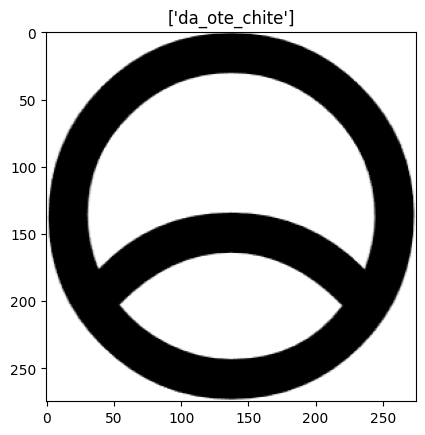

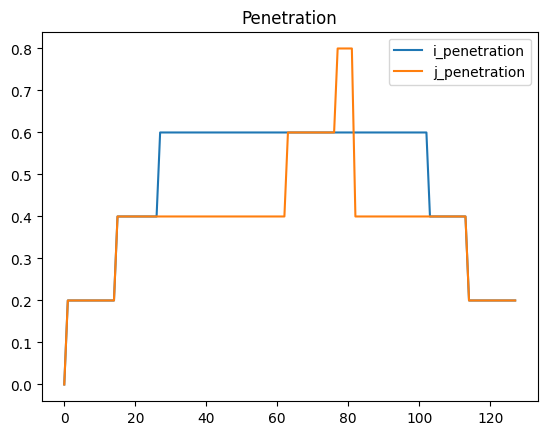

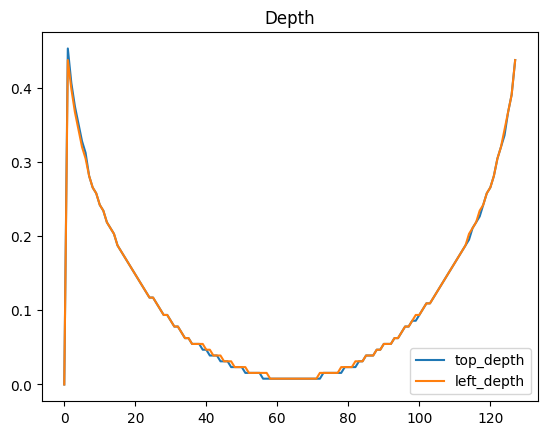

In [27]:
model_loaded = SimpleNN(input_size, hidden_size, num_classes)

model_loaded.load_state_dict(torch.load("simple_nn.pth", weights_only=True))

# input_image = cv.imread('./ma_test2.png')
# input_image = cv.imread('./bad_ma.png')
# input_image = cv.imread('./nange.png')
# input_image = cv.imread('./kagyi.png')
# input_image = cv.imread('./fat_pha.png')
# input_image = cv.imread('./da_ote.png')
# input_image = cv.imread('./tatalinchate.png')
# input_image = cv.imread('./yakout.png')
# input_image = cv.imread('./cut_ma.png')
# input_image = cv.imread('./kha.png')
# input_image = cv.imread('./sa_test.png')
# input_image = cv.imread("./ba_test.png")
# input_image = cv.imread("./salein_test.png")
input_image = cv.imread("./yag.png")
# input_image = cv.imread("./da.png")
# input_image = cv.imread('./data/မ/ma.png')

data = CharData(input_image)

data.normalize(5, 5, data.sample_count, data.sample_count)

features = vectorise_features(data, 1)

features_tensor = torch.tensor(features, dtype=torch.float32)
features_tensor = features_tensor.unsqueeze(0)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_loaded.to(device)
features_tensor = features_tensor.to(device)

model.eval()
with torch.no_grad():
    outputs = model_loaded(features_tensor)
    _, predicted = torch.max(outputs.data, 1)
    confidences = torch.nn.functional.softmax(outputs, dim=1)
    print(f"Predicted: {label_encoder.inverse_transform(predicted.cpu().numpy())} {predicted.cpu().numpy()}")
    
    print("\nConfidences:")
    for idx, label in enumerate(label_encoder.classes_):
        print(f"{label}: {confidences[0][idx].cpu().numpy():.2f}")

    plt.imshow(input_image)
    plt.title(label_encoder.inverse_transform(predicted.cpu().numpy()))
    plt.show()

    plt.title(f"Penetration")
    plt.plot(data.i_penetration, label="i_penetration")
    plt.plot(data.j_penetration, label="j_penetration")
    plt.legend()
    plt.show()

    plt.title(f"Depth")
    plt.plot(data.top_depth, label="top_depth")
    plt.plot(data.left_depth, label="left_depth")
    plt.legend()
    plt.show()